Simple Exact Diagonalisation Code
---------------------------------
Author: Markus Wallerberger.

Released under the GNU General Public License, version 2 or later.

In [1]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as pl
%matplotlib inline

Annihilation operators of a fermionic Fock space in the occupation number basis.

The operators are given in the occupation number basis, where the $i$-th set
bit corresponds to the $i$-th state being present in the many-body state. For
a, e.g., Hilbert space with eight states 0 .. 7, state number 69 would represent:

          i = 7, 6, 5, 4, 3, 2, 1, 0      bit pattern    alpha
            | 0, 1, 0, 0, 0, 1, 0, 1 >  =  0b01000101  =   69

The fermionic anti-commutation relation requires a sign convention: for the
annihilation operator $c_i$, we choose it as $(-1)^{N_\alpha}$ where $N_\alpha$
is the number of electrons of flavour $k < i$ being occupied for the
many-body state $\alpha$.

In [2]:
def get_annihilators(nflavours):
    nfock = 2**nflavours
    fock_range = np.arange(nfock)

    c = [None] * nflavours
    sign = np.ones(nfock, np.int8)
    bitmask = 1
    for i in range(nflavours):
        # The operator c_i removes the state i, which is equivalent to
        # shifting the Fock state 2**i to the left or occupying the +2**i'th
        # side diagonal, but only if the state is indeed present (has_i).
        # Diagonal storage always starts at column 0 (the first rows in the
        # c operators being "above" the matrix)
        has_i = np.array(fock_range & bitmask, dtype=np.bool)
        c[i] = sparse.dia_matrix((has_i * sign, bitmask),
                                 shape=(nfock, nfock), dtype=np.int8).todense()

        # The sign is (-1)**n, where n is the number of occupied states
        # smaller than (ordered before) i.  So, for the next step we flip
        # the sign of those elements where the current state is present.
        sign[has_i] *= -1
        bitmask <<= 1
    
    return c

In [3]:
# Check, e.g., anticommutator
c = get_annihilators(2)
c[0] * c[1] + c[1] * c[0]

matrix([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=int8)

Construct the Hamiltonian of the Anderson model for a finite bath:
$$
    H = U c^\dagger_\uparrow c_\uparrow c^\dagger_\downarrow c_\downarrow 
        - \mu (c^\dagger_\uparrow c_\uparrow  + c^\dagger_\downarrow c_\downarrow ) 
        + \sum_{k,\sigma} (V_{k\sigma} f^\dagger_{k\sigma} c_\sigma 
            + V^*_{k\sigma} c^\dagger_\sigma f_{k\sigma})
        + \sum_{k,\sigma} \epsilon_{k\sigma} f^\dagger_{k\sigma} f_{k\sigma},
$$
where $c_\sigma$ annihilates a local fermion of spin $\sigma$ and $f_{k\sigma}$ annhilates a
bath fermion of spin $\sigma$ and, in this case, discrete momentum $k$.

In [4]:
beta = 10
u_value = 1.0
mu = 0.5
#epsk = []
#vk = []
epsk = [-0.5, 0.5]
vk = [1., 1.]

In [5]:
def get_system(u_value, mu, epsk, vk):
    nbath = len(epsk)
    annh = get_annihilators(2 * (1 + nbath))

    # Construct local (non-interacting and interaction part)
    cup, cdown = annh[0:2]
    hloc = -mu * (cup.T * cup + cdown.T * cdown)
    hint = u_value * cup.T * cup * cdown.T * cdown

    # For each bath site, construct hybridisation and bath energy
    hhyb = 0
    hbath = 0
    for k, (eps, v) in enumerate(zip(epsk, vk)):
        fup, fdown = annh[2*k+2:2*k+4]
        hhyb = (hhyb + v * fup.T * cup + np.conj(v) * cup.T * fup
                + v * fdown.T * cdown + np.conj(v) * cdown.T * fdown)
        hbath = hbath + eps * fup.T * fup + eps * fdown.T * fdown
        
    return annh, hloc + hint + hhyb + hbath

In [6]:
annh, ham = get_system(u_value, mu, epsk, vk)

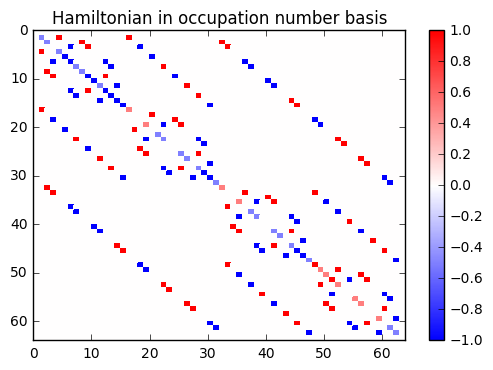

In [7]:
pl.pcolormesh(np.array(ham), cmap='bwr', vmin=-1, vmax=1)
pl.colorbar()
pl.title("Hamiltonian in occupation number basis")
pl.axis('tight')
pl.gca().invert_yaxis()

Diagonalise the many-body Hamiltonian exactly (we can do this since it is small):
$ H = B\ \mathrm{diag}(E)\ B^\dagger $. 
To be consistent, we also rotate the creation and annihilation operators in the eigenbasis:
$ \tilde c_i = B^\dagger c_i B $.

In [8]:
e, basis = np.linalg.eigh(ham)
annh_tilde = [basis.conj().T * ci * basis for ci in annh]

It is convenient to shift all energies such that the ground state $E_0 = 0$, because else both
the denominator and the numerator in expectation values may become large. Afterwards, $Z$ becomes essentially the degeneracy of the ground state (at least at large $\beta$)

In [9]:
def evolve(tau):
    global e
    return np.diag(np.exp(-tau * e))

In [10]:
z = evolve(beta).sum()
print "Before shifting: Z =", z

e -= e.min()
z = evolve(beta).sum()
print "After shifting:  Z =", z

Before shifting: Z = 5.88819169361e+14
After shifting:  Z = 3.87936702286


Compute the Green's function in small imaginary time steps as:
$$
    G_{ij}(\tau) = -\frac 1Z \mathrm{tr}\big(e^{-(\beta-\tau)H} c_i(\tau) e^{-\tau H} c^\dagger_j(0)\big)
                 = -\frac 1Z \mathrm{tr}\big( 
                    \mathrm{diag}(e^{-(\beta-\tau)E})\ \tilde c_i(\tau) 
                    \ \mathrm{diag}(e^{-\tau E})\ \tilde c^\dagger_j(0)\big)
$$

In [11]:
tau = np.linspace(0, beta, 100, True)
gtau = np.zeros_like(tau)
oper1 = annh_tilde[0]
oper2 = annh_tilde[0].conj().T
for i, t in enumerate(tau):
    gtau[i] = (evolve(beta - t) * oper2 * evolve(t) * oper1).trace()
gtau /= -z

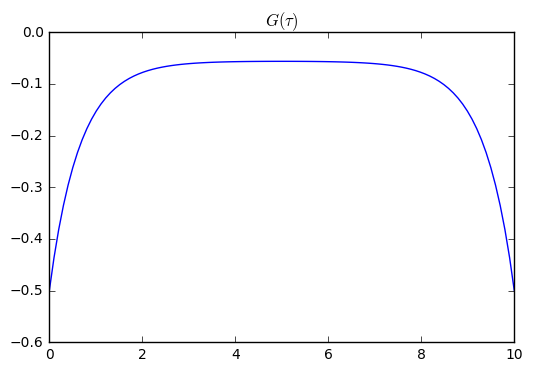

In [14]:
pl.plot(tau, gtau)
pl.title(r"$G(\tau)$");

Post-mortem
-----------
  * We have derived a fairly general method for small many-body Hamiltonians:
    the method can be generalised to multiple orbitals/sites pretty easily.
  
  * What is missing for DMFT is to compute the Green's function on the
    Matsubara axis by a Fourier transform and then also the self-energy.
  
  * The main bottleneck of ED is *memory*: the matrices involved grow as $4^{2N}$,
    where $N$ is the number of bath plus local orbitals.  One can remedy that in
    a couple of ways:
    
      1. From the pseudocolor plot we conjecture that $H$ stays fairly sparse.  We
         can therefore use sparse arithmetic (`scipy.sparse`) to store all matrices
         and hopefully bring the scaling down to $4^N$.

      2. We need to think about the diagonalisation step then, however.  We can do this
         by decomposing the Hamiltonian into blocks (Hint: this is equivalent to a graph
         problem -- `scipy.sparse.csgraph.connected_components`) and using dense algorithms
         on the blocks.  This also allows us to use the block structure in the computation
         of the Green's function.
      
      3. Especially for low temperatures, we can alternatively use the Lanczos procedure to
         truncate the outer trace for the Green's function computation to the lowest-lying
         eigenstates.
         
      4. If we work with blocks, we can also distribute them across computing nodes
         (`mpi4py`).